from vLLM website
```bash
vllm serve meta-llama/Llama-3.1-8B-Instruct \
    --enable-auto-tool-choice \
    --tool-call-parser llama3_json \
    --chat-template examples/tool_chat_template_llama3.1_json.jinja
```

CUDA_VISIBLE_DEVICES="2,3,4,5" vllm serve meta-llama/Llama-3.3-70B-Instruct --download-dir $MODEL_PATH --tensor-parallel-size 4 --max-model-len 32768 --enable-auto-tool-choice --tool-call-parser llama3_json --chat-template /tool_chat_template_llama3.2_json.jinja

```bash
CUDA_VISIBLE_DEVICES="2,3,4,5" python -m vllm.entrypoints.openai.api_server \
--model meta-llama/Llama-3.3-70B-Instruct \
--download-dir $MODEL_PATH \
--tensor-parallel-size 4 \
--max-model-len 32768 \
--enable-auto-tool-choice \
--tool-call-parser llama3_json \
--chat-template /home/yl3427/tool_chat_template_llama3.3_json.jinja
```

Known issues:

Parallel tool calls are not supported.

The model can generate parameters with a wrong format, such as generating an array serialized as string instead of an array.

The tool_chat_template_llama3_json.jinja file contains the “official” Llama chat template, but tweaked so that it works better with vLLM.

Recommended flags: --tool-call-parser llama3_json --chat-template examples/tool_chat_template_llama3_json.jinja

In [15]:
df.columns

Index(['File ID', 'Assessment', 'Summary', 'Subjective', 'Objective',
       'cleaned_expanded_Summary', 'terms', 'combined_summary', 'pred_sepsis',
       'reasoning_sepsis'],
      dtype='object')

In [5]:
import pandas as pd
df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/MA_results/diag_0302_from90th_resumed.csv')
orig_df = pd.read_csv('/home/yl3427/cylab/SOAP_MA/MA_results/diag_0302.csv')
for idx, row in df.iterrows():
    if pd.isna(row['pred_sepsis']):
        # print(idx)
        print(row["File ID"], idx)
        print(orig_df.index[orig_df['File ID'] == row["File ID"]])
    

148906.txt 18
Index([155], dtype='int64')
100746.txt 102
Index([239], dtype='int64')
127339.txt 142
Index([279], dtype='int64')
150956.txt 172
Index([309], dtype='int64')
156778.txt 176
Index([313], dtype='int64')
175627.txt 197
Index([334], dtype='int64')


In [ ]:
from openai import OpenAI
import json

client = OpenAI(base_url="http://localhost:8000/v1", api_key="dummy")

def get_weather(location: str, unit: str):
    return f"Getting the weather for {location} in {unit}..."
tool_functions = {"get_weather": get_weather}

tools = [{
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {"type": "string", "description": "City and state, e.g., 'San Francisco, CA'"},
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]}
            },
            "required": ["location", "unit"]
        }
    }
}]

response = client.chat.completions.create(
    model=client.models.list().data[0].id,
    messages=[{"role": "user", "content": "What's the weather like in San Francisco?"}],
    tools=tools,
    tool_choice="auto"
)

tool_call = response.choices[0].message.tool_calls[0].function
print(f"Function called: {tool_call.name}")
print(f"Arguments: {tool_call.arguments}")
print(f"Result: {get_weather(**json.loads(tool_call.arguments))}")

Function called: get_weather
Arguments: {"location": "San Francisco, CA", "unit": "fahrenheit"}
Result: Getting the weather for San Francisco, CA in fahrenheit...


In [17]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-ba413aedf8114f3ab990ed0d00fd2387', function=Function(arguments='{"location": "San Francisco, CA", "unit": "fahrenheit"}', name='get_weather'), type='function')], reasoning_content=None)

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI

local_api_url = "http://localhost:8000/v1"
model="meta-llama/Llama-3.3-70B-Instruct"
llm = ChatOpenAI(
    model=model,
    openai_api_base=local_api_url,   
    temperature=0.7,
    openai_api_key="dummy_key",                     
)

#### **API 키 설정**

In [4]:
import os
from dotenv import load_dotenv
load_dotenv('/home/yl3427/.env')
# os.environ['TAVILY_API_KEY']
os.getenv('TAVILY_API_KEY')
os.environ['TAVILY_API_KEY']

'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'

#### **웹 검색과 코드 실행 도구 정의**

In [5]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

#### **yfinance로 주어진 주식 종목에 대한 최근 주가 및 재무 분석 도구 정의**

In [6]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2025-02-20': 140.11000061035156,
 '2025-02-21': 134.42999267578125,
 '2025-02-24': 130.27999877929688,
 '2025-02-25': 126.62999725341797,
 '2025-02-26': 131.27999877929688}

In [7]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.
    
    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

#### **Supervisor 에이전트 정의**

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal["Researcher", "Stock_Analyzer", "Chart_Generator", "FINISH"]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

#### **하위 에이전트 정의 함수**

In [9]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

#### **하위 에이전트 설정**

In [10]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools = [tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [11]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

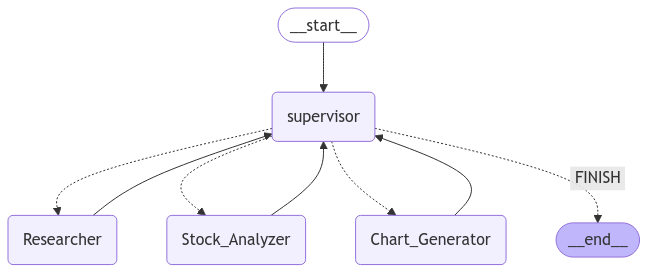

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [18]:
llm_tools = llm.bind_tools([stock_analysis])

In [19]:
res= llm_tools.invoke("what is the stock price of AAPL?")

In [20]:
res

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-5540b7c8615440849fc1588490013ae6', 'function': {'arguments': '{"ticker": "AAPL"}', 'name': 'stock_analysis'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 267, 'total_tokens': 291, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94f79aaf-41ad-42fe-b084-ac7a410fb34e-0', tool_calls=[{'name': 'stock_analysis', 'args': {'ticker': 'AAPL'}, 'id': 'chatcmpl-tool-5540b7c8615440849fc1588490013ae6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 24, 'total_tokens': 291, 'input_token_details': {}, 'output_token_details': {}})

In [17]:
res[0].content

TypeError: 'AIMessage' object is not subscriptable

In [11]:
import json
@tool
def get_flight_info(loc_origin: str, loc_destination: str):
    """
    Get flight information between two locations.
    """
    flight_info = {
    "loc_origin": loc_origin,
    "loc_destination": loc_destination,
    "datetime": str(datetime.now() + timedelta(hours=2)),
    "airline": "KLM",
    "flight_number": "KL 123",
    }

    return json.dumps(flight_info)

@tool
def greet_user(name: str) -> str:
    """
    Greet the user with a personalized message.
    """
    return f"Hello, {name}! Sure, I can help you with that."
 
prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        ("user", "{input}"),
    ]
)
llm_with_tool = llm.bind_tools([get_flight_info])
chain = prompt | llm
chain.invoke("Hello, My name is Yewon. When's the next flight from Amsterdam to New York?")

AIMessage(content="Hello Yewon! Nice to meet you!\n\nTo find the next flight from Amsterdam to New York, I'd be happy to help you with that. However, I'm a large language model, I don't have have access to real-time flight information. But I can suggest a few options to help you find the next available flight:\n\n1. **Check with airlines**: You can visit the websites of airlines that operate flights from Amsterdam to New York, such as KLM, Delta, or American Airlines, to see their flight schedules and book a ticket.\n2. **Use flight search engines**: Websites like Google Flights, Skyscanner, or Expedia can help you search for flights from Amsterdam to New York and provide you with a list of available flights, along with their departure and arrival times.\n3. **Contact a travel agent**: If you prefer to book through a travel agent, they can help you find the next available flight and assist with the booking process.\n\nIf you'd like, I can help you with some general information about fl

In [ ]:
from langchain_core.tools import tool



llm_with_tool = llm.bind_tools([get_flight_info])
resp = llm_with_tool.invoke("Hello, I'm Yewon. What is 'apple' in Korean?")
print(resp)

In [ ]:
# invoke test
messages = [
    SystemMessage(
        content="You are a helpful assistant that translates English to Italian."
    ),
    HumanMessage(
        content="Translate the following sentence from English to Italian: I love programming."
    ),
]
llm.invoke(messages)

# Chain test
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("user", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

# Tool calling test
from langchain_core.tools import tool

# 定义一个工具函数
@tool
def greeting(name: str) ->str : 
    ''''''
    return f"你好啊, {name}"
 
llm_with_tool = llm.bind_tools([greeting])
resp = llm_with_tool.invoke("你好，我是Jean，问候一下。")
print(resp)

content='' additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-3193df7609014e46be0ab78417bbee0d', 'function': {'arguments': '{"name": "Jean"}', 'name': 'greeting'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 183, 'total_tokens': 206, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-db9a2b19-0671-44d9-82ae-b48baef4fd72-0' tool_calls=[{'name': 'greeting', 'args': {'name': 'Jean'}, 'id': 'chatcmpl-tool-3193df7609014e46be0ab78417bbee0d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 183, 'output_tokens': 23, 'total_tokens': 206, 'input_token_details': {}, 'output_token_details': {}}


In [28]:
import ast
# x = resp.additional_kwargs
# ast.literal_eval(x)

In [33]:
functions = {
    "greeting": greeting
}

In [30]:
func_name

'greeting'

In [35]:
func_name = resp.additional_kwargs['tool_calls'][0]['function']['name']
func_args = resp.additional_kwargs['tool_calls'][0]['function']['arguments']
functions[func_name](ast.literal_eval(func_args))

'你好啊, Jean'